In [1]:
import sys
sys.path.append("../../")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.test_functions.multi_objective import GMM, BraninCurrin
from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cpu"),
}

In [3]:
from pymoo.core.problem import Problem

# define problem
botorch_problem = GMM(negate=True).to(**tkwargs)
# problem = BraninCurrin(negate=True).to(**tkwargs)
botorch_problem.ref_point = torch.tensor([0., 0.], **tkwargs)

# pymoo problem
def get_pymoo_problem(problem):
    class MyProblem(Problem):
        def __init__(self):
            super().__init__(
                n_var=problem.dim,
                n_obj=problem.num_objectives,
                n_constr=0,
                xl=problem.bounds[0].numpy(),
                xu=problem.bounds[1].numpy()
            )

        def _evaluate(self, x, out, *args, **kwargs):
            out["F"] = - problem(torch.from_numpy(x)).numpy()

    return MyProblem()

problem = get_pymoo_problem(botorch_problem)

In [4]:
def plot_objective(problem, num_samples: int = 200):
    num_dim = problem.n_var
    num_obj = problem.n_obj

    fig = plt.figure(figsize=(5 * (num_dim + 1), 5))

    # only plot the first two dimensions
    xx, yy = np.meshgrid(
        np.linspace(
            *np.stack(problem.bounds(), axis=0).T[0], num_samples
        ),
        np.linspace(
            *np.stack(problem.bounds(), axis=0).T[1], num_samples
        ),
    )
    input_data = np.vstack((xx.flatten(), yy.flatten())).T
    z = problem(input_data)
    pareto = is_non_dominated(torch.from_numpy(z)).cpu()
    pareto_set = z.cpu().numpy().copy()
    pareto_set[~pareto] = np.nan

    for i in range(num_dim):
        ax = plt.subplot2grid((1, num_dim + 1), (0, i))
        div = make_axes_locatable(ax)
        cax = div.append_axes('right', '5%', '5%')

        # plot functions
        countourset = ax.contourf(
            xx,
            yy,
            z[:, i].reshape(xx.shape),
        )

        # plot pareto set mask
        ax.scatter(*input_data[pareto].t(), color='tab:red', s=10, label='pareto set')

        cax.grid(False)  # just to remove the warning
        clb = fig.colorbar(countourset, cax=cax)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(f"objective {i+1}")
        ax.legend()
        clb.ax.set_title('z')

    ax_pareto = plt.subplot2grid((1, num_dim + 1), (0, num_dim))
    idx = np.argsort(pareto_set[:, 0])
    ax_pareto.plot(*pareto_set[idx].T, color='tab:red', label='approximated pareto front')
    ax_pareto.scatter(*pareto_set[idx].T, color='tab:red', s=10)
    ax_pareto.scatter(*problem.ref_point.cpu().t(), color='tab:red', marker='x', label='refence point')
    ax_pareto.set_title("pareto front")
    ax_pareto.legend()
    plt.tight_layout()

In [5]:
def generate_initial_data(problem, n=6):
    # generate training data
    train_x = draw_sobol_samples(bounds=problem.bounds, n=n, q=1).squeeze(1)
    train_obj = problem(train_x)
    return train_x, train_obj

In [6]:
init_x, init_y = generate_initial_data(botorch_problem, n=10)

## Generate data

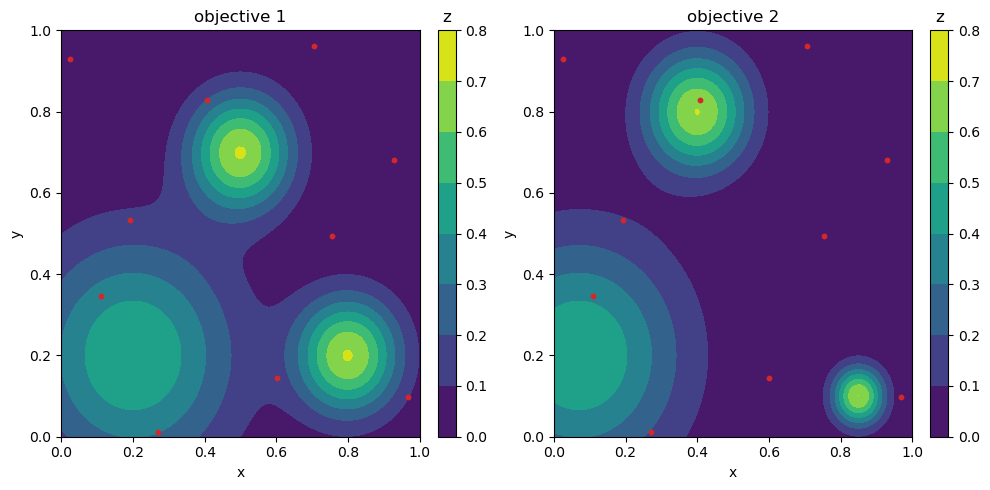

In [7]:
num_dim = problem.n_obj
# only plot the first two dimensions
xx, yy = np.meshgrid(
    np.linspace(
        *np.stack(problem.bounds(), axis=0).T[0], 200
    ),
    np.linspace(
        *np.stack(problem.bounds(), axis=0).T[1], 200
    ),
)
input_data = np.vstack((xx.flatten(), yy.flatten())).T
z = - problem.evaluate(input_data)

fig = plt.figure(figsize=(5 * (num_dim), 5))
for i in range(num_dim):
    ax = plt.subplot2grid((1, num_dim), (0, i))
    div = make_axes_locatable(ax)
    cax = div.append_axes('right', '5%', '5%')

    # plot functions
    countourset = ax.contourf(
        xx,
        yy,
        z[:, i].reshape(xx.shape),
    )

    # plot observations
    ax.scatter(*init_x.cpu().t(), s=10, color='tab:red')

    cax.grid(False)  # just to remove the warning
    clb = fig.colorbar(countourset, cax=cax)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f"objective {i+1}")
    clb.ax.set_title('z')
plt.tight_layout()

In [8]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

optimizer = NSGA2(pop_size=100)
res = minimize(problem,
               optimizer,
               ('n_gen', 10),
               seed=5,
               verbose=False)

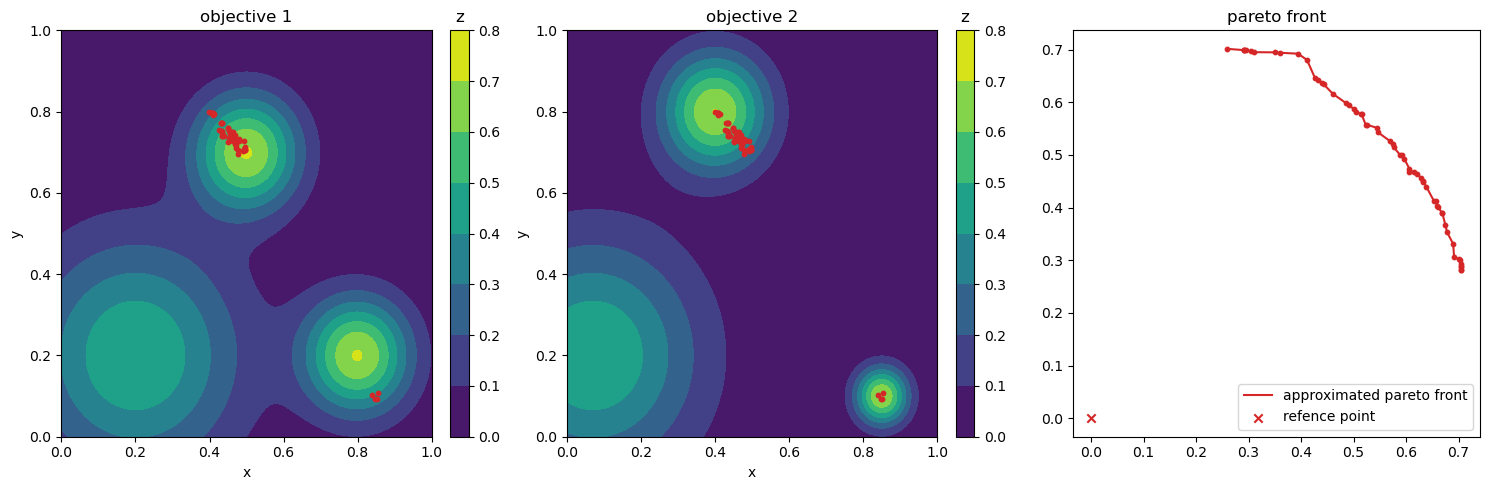

In [9]:
num_dim = problem.n_obj
# only plot the first two dimensions
xx, yy = np.meshgrid(
    np.linspace(
        *np.stack(problem.bounds(), axis=0).T[0], 200
    ),
    np.linspace(
        *np.stack(problem.bounds(), axis=0).T[1], 200
    ),
)
input_data = np.vstack((xx.flatten(), yy.flatten())).T
z = - problem.evaluate(input_data)

fig = plt.figure(figsize=(5 * (num_dim+1), 5))
for i in range(num_dim):
    ax = plt.subplot2grid((1, num_dim+1), (0, i))
    div = make_axes_locatable(ax)
    cax = div.append_axes('right', '5%', '5%')

    # plot functions
    countourset = ax.contourf(
        xx,
        yy,
        z[:, i].reshape(xx.shape),
    )

    # plot observations
    ax.scatter(*res.X.T, s=10, color='tab:red')

    cax.grid(False)  # just to remove the warning
    clb = fig.colorbar(countourset, cax=cax)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f"objective {i+1}")
    clb.ax.set_title('z')

ax_pareto = plt.subplot2grid((1, num_dim + 1), (0, num_dim))
idx = np.argsort(-res.F[:, 0])
ax_pareto.plot(*-res.F[idx].T, color='tab:red', label='approximated pareto front')
ax_pareto.scatter(*-res.F[idx].T, color='tab:red', s=10)
ax_pareto.scatter(*botorch_problem.ref_point.cpu().t(), color='tab:red', marker='x', label='refence point')
ax_pareto.set_title("pareto front")
ax_pareto.legend()
plt.tight_layout()